Data + imports

In [1]:
# import argparse
from collections import OrderedDict
import numpy as np
# from scipy import misc
# from imageio import imsave
import torch, cv2, math
# import torch.nn as nn
import torch.nn.functional as F
from data.cocostuff_loader import *
from data.vg import *
from model.resnet_generator_v2 import *
from utils.util import *
import matplotlib.pyplot as plt
from dataclasses import dataclass
# from torchvision.utils import make_grid


def get_dataloader(dataset = 'coco', img_size=128):
    if dataset == 'coco':
        dataset = CocoSceneGraphDataset(image_dir='./datasets/coco/images/val2017/',
                                        instances_json='./datasets/coco/annotations/instances_val2017.json',
                                        stuff_json='./datasets/coco/annotations/stuff_val2017.json',
                                        stuff_only=True, image_size=(img_size, img_size), left_right_flip=False)
    elif dataset == 'vg':
        with open("./datasets/vg/vocab.json", "r") as read_file:
            vocab = json.load(read_file)
        dataset = VgSceneGraphDataset(vocab=vocab,
                                      h5_path='./datasets/vg/val.h5',
                                      image_dir='./datasets/vg/images/',
                                      image_size=(128, 128), left_right_flip=False, max_objects=30)

    dataloader = torch.utils.data.DataLoader(
                    dataset, batch_size=1,
                    drop_last=True, shuffle=False, num_workers=1)
    return dataloader, dataset.vocab['object_idx_to_name']

Load model and data

In [2]:
@dataclass
class MyArgs:
    dataset: str = ''
    model_path: str = ''
    sample_path: str = ''

args = MyArgs()
args.dataset = 'coco'
args.model_path = 'outputs/model/G_65.pth'
args.sample_path = 'samples/test/'

num_classes = 184 if args.dataset == 'coco' else 179
num_o = 8 if args.dataset == 'coco' else 31

dataloader, idx2name = get_dataloader(args.dataset)

netG = ResnetGenerator128(num_classes=num_classes, output_dim=3).cuda()

if not os.path.isfile(args.model_path):
    print('Model not found')
    raise FileNotFoundError('Model not found')

state_dict = torch.load(args.model_path)

new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k[7:]  # remove `module.`nvidia
    new_state_dict[name] = v

model_dict = netG.state_dict()
pretrained_dict = {k: v for k, v in new_state_dict.items() if k in model_dict}
model_dict.update(pretrained_dict)
netG.load_state_dict(model_dict)

netG.cuda()
netG.eval()

if not os.path.exists(args.sample_path):
    os.makedirs(args.sample_path)
thres=2.0

called set_image_size (128, 128)


Functions

In [3]:
def draw_bounding_boxes(img_tens: torch.Tensor, bbox, labels, text=True):
    img_np = img_tens.cpu().numpy()

    for i, box in enumerate(bbox.cpu().numpy()[0]):

        # rescale and convert to int
        box = [int(c*img_np.shape[0]) for c in box]

        xl, yl, w, h = box
        cv2.rectangle(img_np, (xl, yl), (xl+w, yl+h), (255,0,0), 1)
        if text:
            cv2.putText(img_np, idx2name[labels[i]], (xl, yl+10), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255,0,0), 1)
    
    return img_np

In [4]:
def experiment(variable, num_gen=23, max_cols=6, figsize=(20,13), skip=0, transform_bbox=None):

    fakes = []

    it = iter(dataloader)

    for _ in range(skip):
        _ = it.next()

    # fixed
    if not 'layout' in variable:
        real_images, label, bbox = next(it)
        layout = torch.ones(128, 128)
        layout = draw_bounding_boxes(layout, bbox, label.cpu().numpy()[0])
        real_images, label = real_images.cuda(), label.long().unsqueeze(-1).cuda()
        fakes.append(layout)
    if not 'z_obj' in variable:
        z_obj = torch.from_numpy(truncted_random(num_o=num_o, thres=thres)).float().cuda()
    if not 'z_img' in variable:
        z_im = torch.from_numpy(truncted_random(num_o=1, thres=thres)).view(1, -1).float().cuda()

    # varying
    for idx in range(num_gen):
        if 'layout' in variable:
            real_images, label, bbox = it.next()
            layout = torch.ones(128, 128)
            layout = draw_bounding_boxes(layout, bbox, label.cpu().numpy()[0])
            real_images, label = real_images.cuda(), label.long().unsqueeze(-1).cuda()
            fakes.append(layout)
        
        bbox_cp = bbox.clone()

        if not transform_bbox is None and idx > 0:
            for box_i in transform_bbox:
                xl, yl, w, h = bbox_cp[0][box_i]
                bbox_cp[0][box_i] = torch.tensor([xl+random.uniform(-0.5,0.5), yl+random.uniform(-0.5,0.5), w*random.uniform(0,2), h*random.uniform(0,2)])
            
            layout = torch.ones(128, 128)
            layout = draw_bounding_boxes(layout, bbox_cp, label.cpu().numpy()[0], text=False)
            # real_images, label = real_images.cuda(), label.long().unsqueeze(-1).cuda()
            fakes.append(layout)

        if 'z_obj' in variable:
            z_obj = torch.from_numpy(truncted_random(num_o=num_o, thres=thres)).float().cuda()
        if 'z_img' in variable:
            z_im = torch.from_numpy(truncted_random(num_o=1, thres=thres)).view(1, -1).float().cuda()

        fake_images = netG.forward(z_obj, bbox_cp.cuda(), z_im, label.squeeze(dim=-1))

        fakes.append(np.transpose(fake_images[0].detach().cpu().numpy(), (1,2,0)) * 0.5 + 0.5)

    # print(int(math.ceil((len(fakes))/6)))
    n_rows = int(math.ceil((len(fakes))/6))
    _, axs = plt.subplots(n_rows, max_cols, figsize=figsize)

    for idx, image in enumerate(fakes):
        row = idx // max_cols
        col = idx % max_cols
        # print(f'{row} {col}')
        if n_rows > 1:
            axs[row, col].axis("off")
            axs[row, col].imshow(image, cmap="gray", aspect="auto")
        else:
            axs[col].axis("off")
            axs[col].imshow(image, cmap="gray", aspect="auto")
    plt.subplots_adjust(wspace=.05, hspace=.05)

Fixed layout, everything else varies

/home/andrea/miniforge3/envs/lost/lib/python3.7/site-packages/torch/nn/functional.py:2423: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


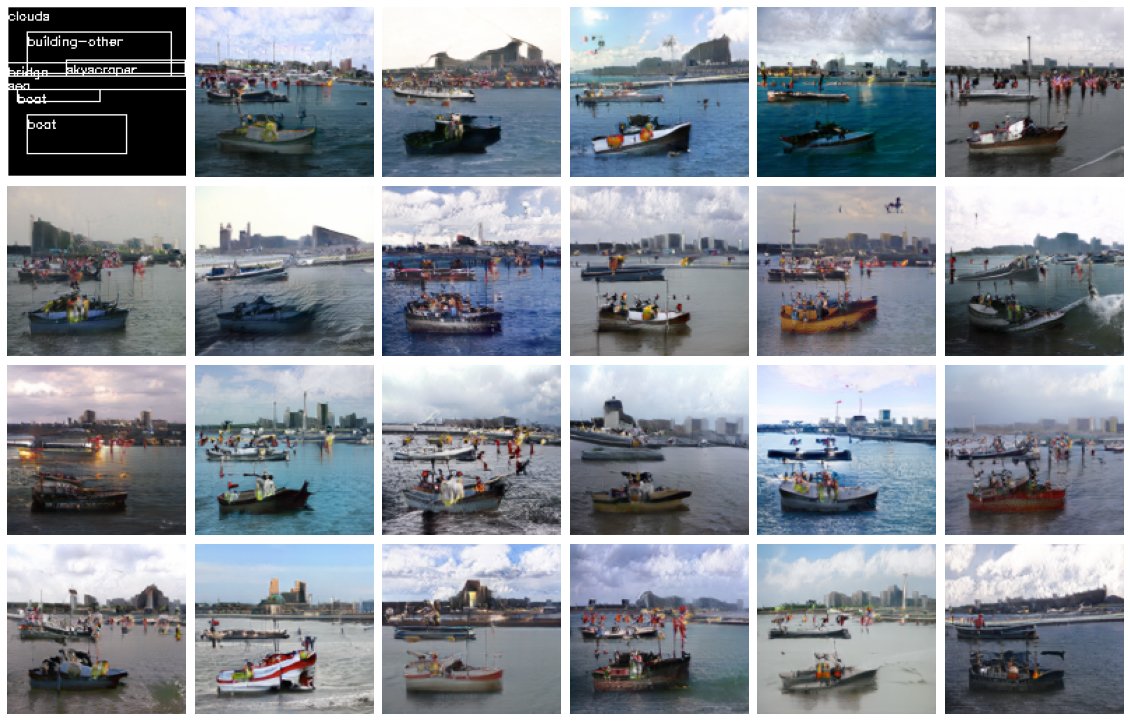

In [5]:
layout_index = 29

experiment(['z_img', 'z_obj'], skip=layout_index)

Only vary image appearance

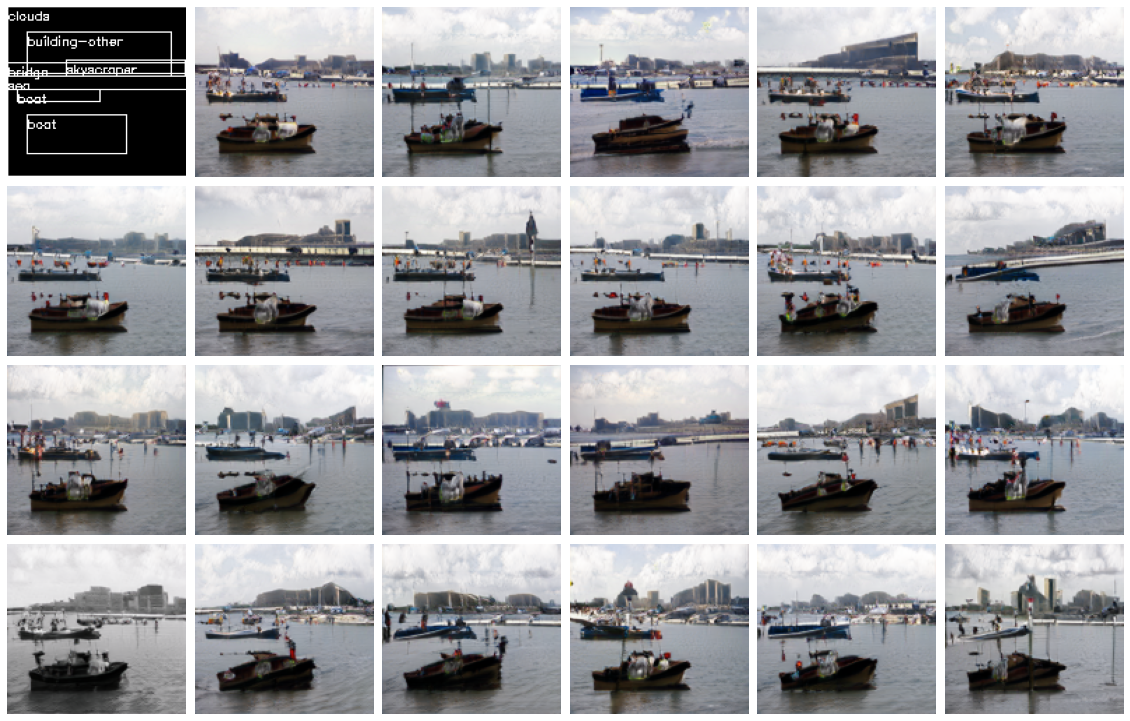

In [6]:
experiment(['z_img'], skip=layout_index)

Vary object appearances

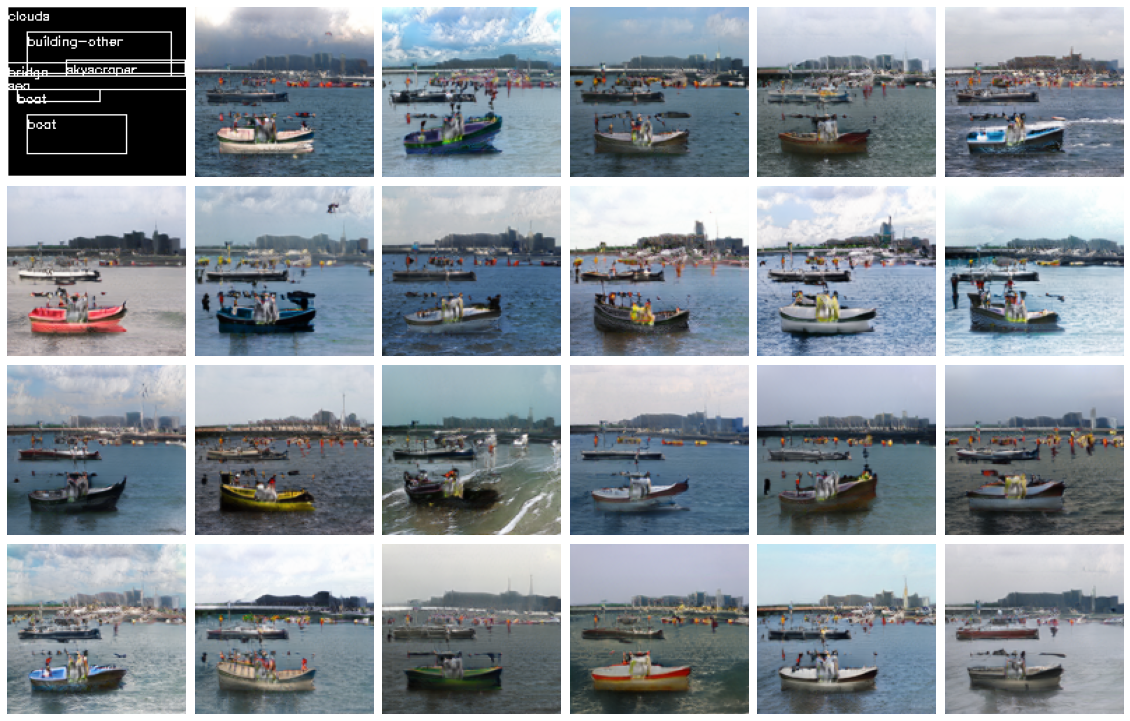

In [7]:
experiment(['z_obj'], skip=layout_index)

Vary layout

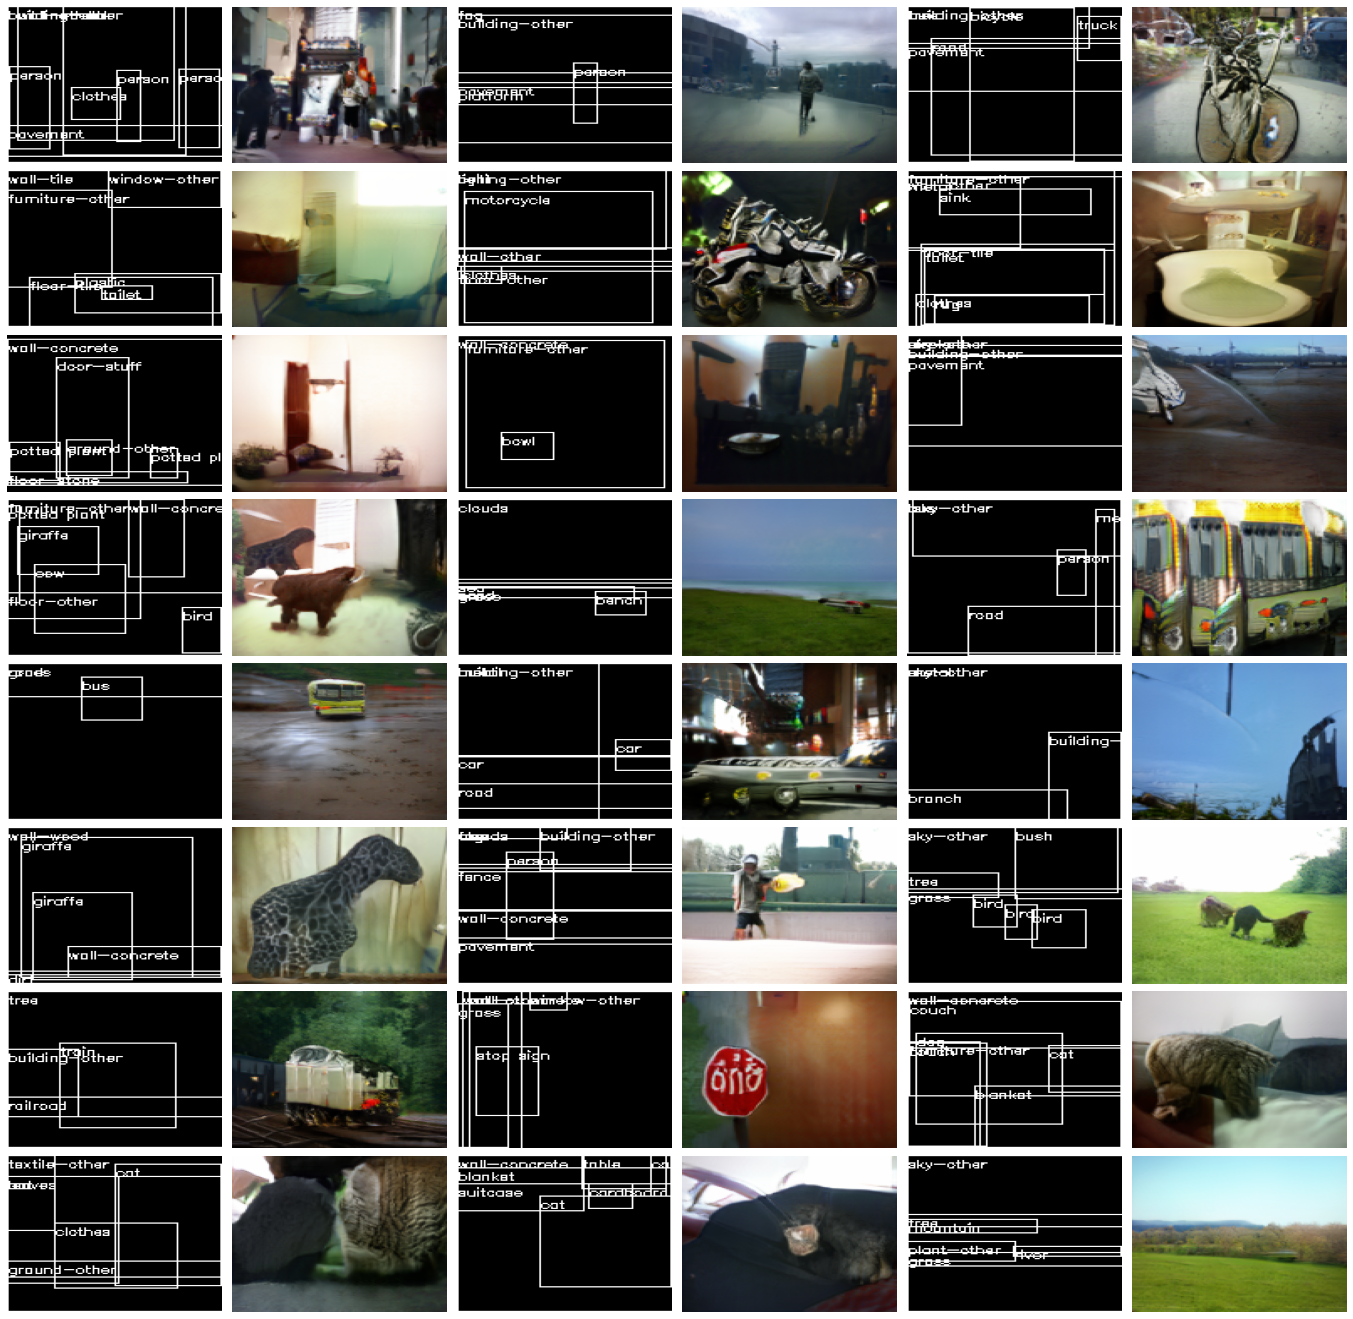

In [8]:
experiment(['layout'], figsize=(24, 24), num_gen=24)

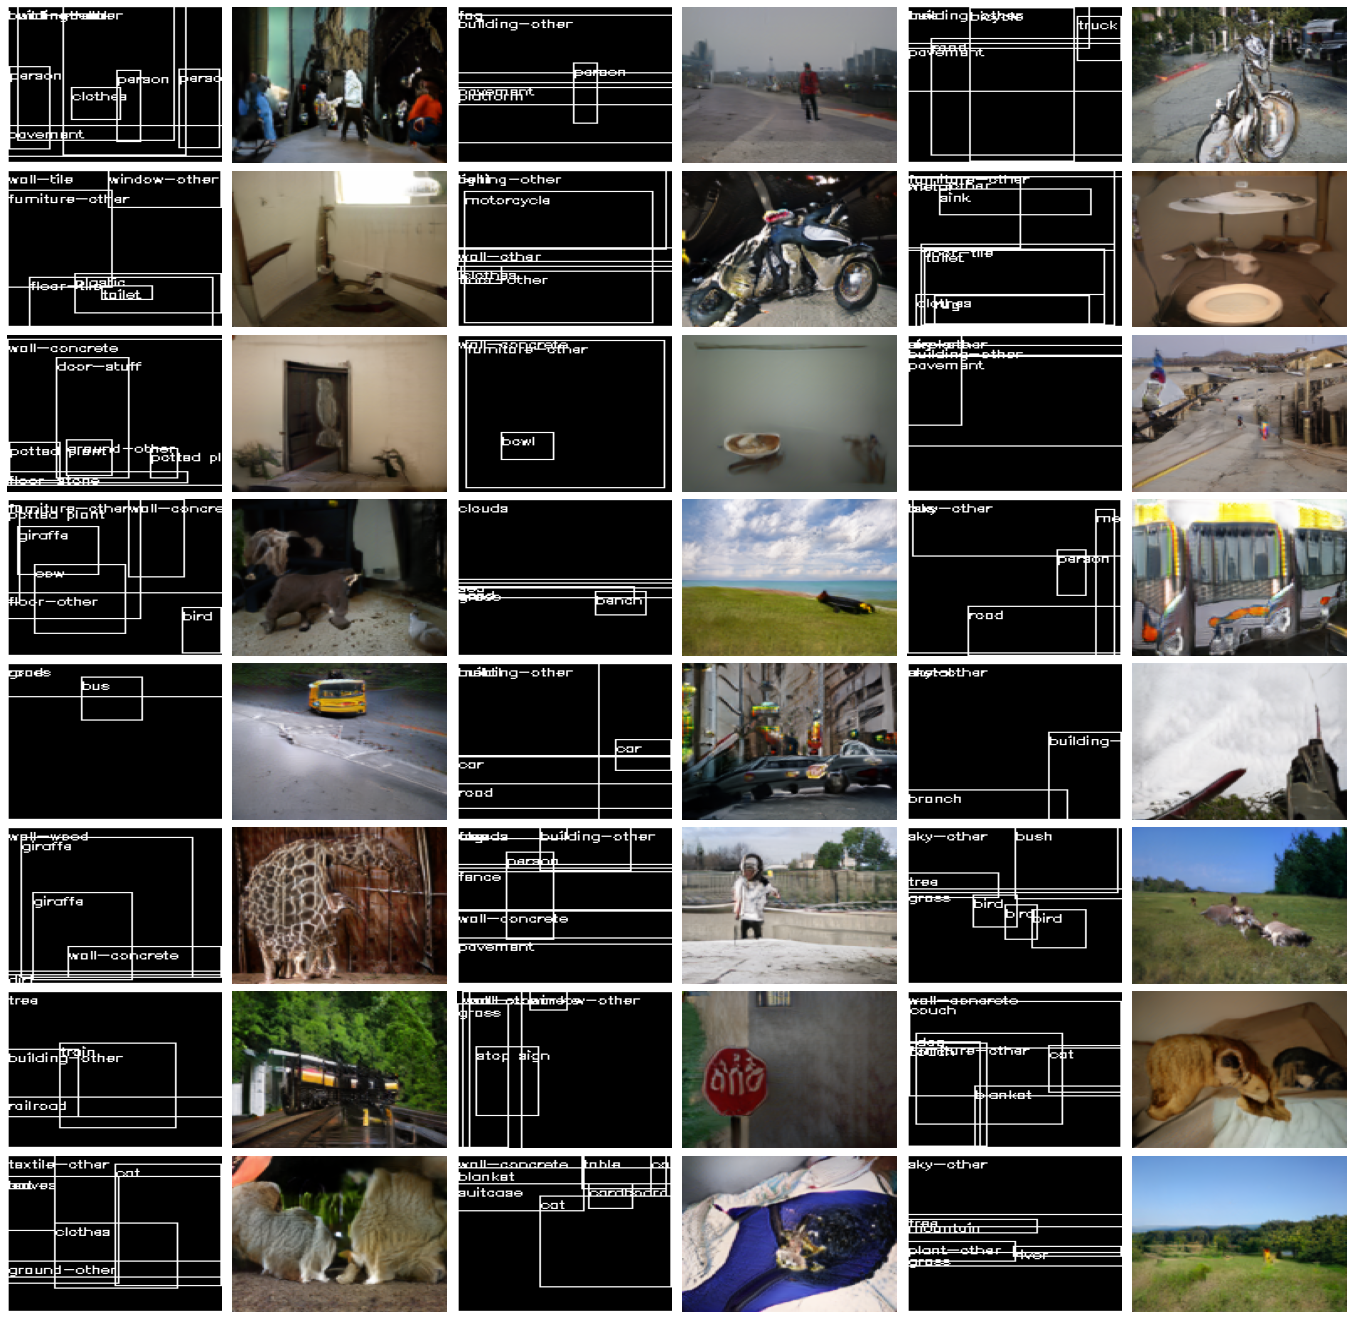

In [9]:
experiment(['layout', 'z_obj'], figsize=(24,24), num_gen=24)

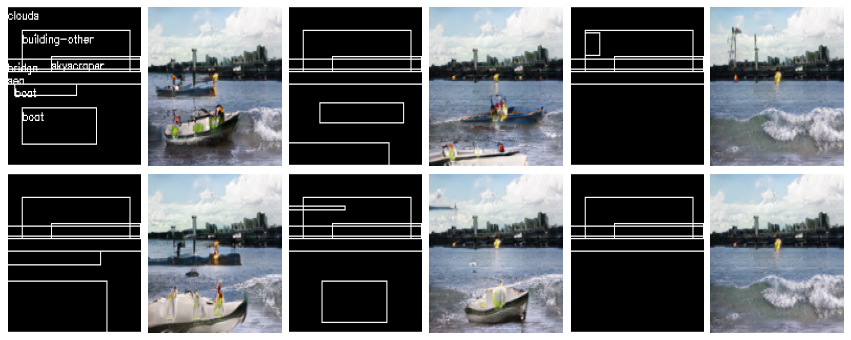

In [16]:
experiment([], figsize=(15, 6), num_gen=6, skip=layout_index, transform_bbox=[0,1])